In [94]:
#Define your race here
year = 2025
track = "British"

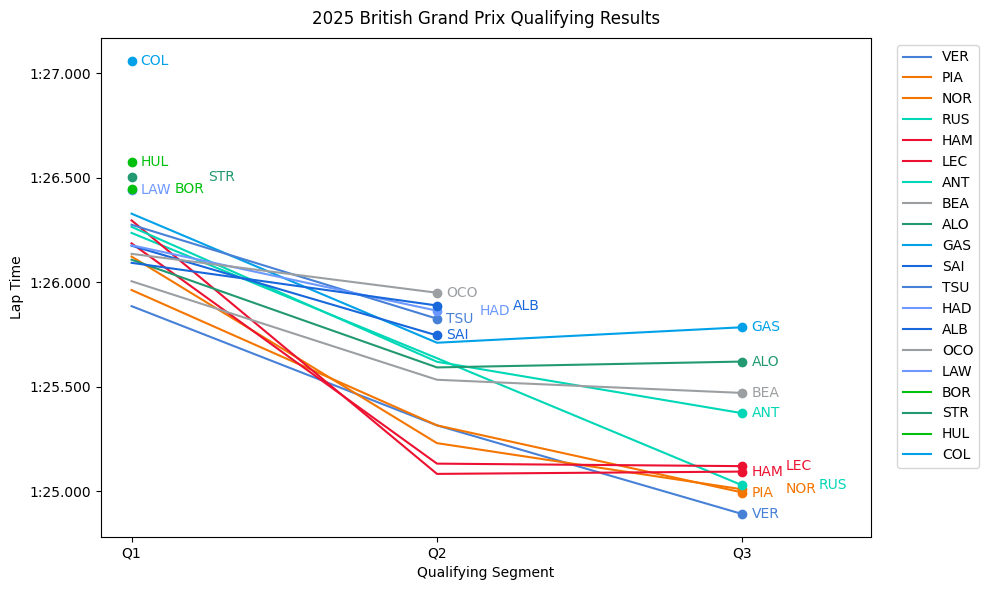

In [93]:
import fastf1
import logging
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

#Removes unecessary logging
fastf1.set_log_level(logging.ERROR)

#Gets data about the given race
session = fastf1.get_session(year, track, 'Q')
session.load()

#Function to convert seconds into the format MM:SS.MMM
def time_format(seconds, _):
    minutes = int(seconds // 60)
    seconds_remaining = int(seconds % 60)
    millis_remaining = int(seconds*1000 % 1000)
    return f"{minutes}:{seconds_remaining:02d}.{millis_remaining:03d}"

#Calculates where to align the x value of the labels to avoid overlap
def get_x_align(placed_x, placed_y, current, y_indent):
    count = 0
    x = 0
    while x < len(placed_y):
        if abs(placed_y[x] - current) < y_indent and count == placed_x[x]:
            count += 1
            x = 0
        else:
            x += 1
    return count

#Gets driver numbers
numbers = session.results.index
results = []
drivers = []
last_session = []

#Gets the results for each driver as well as calculate when they were knocked out
for num in numbers:
    drivers.append(session.get_driver(num)['Abbreviation'])
    current = [
        session.results.Q1.loc[num].total_seconds(),
        session.results.Q2.loc[num].total_seconds(),
        session.results.Q3.loc[num].total_seconds()
    ]
    if current[2] > 0:
        last_session.append(2)
    elif current[1] > 0:
        last_session.append(1)
    else:
        last_session.append(0)
    results.append(current)

#Create a plot
fig, ax = plt.subplots(figsize=(10, 6))

text_placed_x = [[], [], []]
text_placed_y = [[], [], []]
y_indent = ( max(max(results)) - min(min(results)) ) * 0.033
for x in range(0,len(numbers)):
    
    #Get the drivers colour and ensure it isn't too bright to see
    col = session.get_driver(numbers[x])['TeamColor']
    
    if (int(col[0] + col[1], 16) * 299 + int(col[2] + col[3], 16) * 587 + int(col[4] + col[5], 16) * 114) / 1000 > 220:
        col = "555555"

    #Draw the line of the drivers result as well as a dot when they were knocked out
    line = ax.plot(['Q1', 'Q2', 'Q3'], results[x], linestyle='-', color="#"+col, label=drivers[x])
    ax.plot(['Q1', 'Q2', 'Q3'][last_session[x]], results[x][last_session[x]], marker='o', color=line[0].get_color())

    #Write the name of the driver
    current_x_align = get_x_align(text_placed_x[last_session[x]], text_placed_y[last_session[x]], results[x][last_session[x]], y_indent)
    text_placed_x[last_session[x]].append(current_x_align)
    text_placed_y[last_session[x]].append(results[x][last_session[x]])
    ax.text(last_session[x] + 0.03 + current_x_align * 0.11, results[x][last_session[x]], drivers[x], va='center', color=line[0].get_color()) 

#Convert y axis to correct time format
ax.yaxis.set_major_formatter(FuncFormatter(time_format))

#Extend graph size to account for names
x_left, x_right = ax.get_xlim()
ax.set_xlim(x_left, x_right + 0.1 + 0.11 * max(text_placed_x[2])) 

#Write labels on the axis, a legend in the top right, and a title give the race details
ax.set_xlabel('Qualifying Segment')
ax.set_ylabel('Lap Time')
ax.legend(bbox_to_anchor=(1.15, 1))  # Show driver labels
ax.grid(False)
ax.set_title(f'{year} {track} Grand Prix Qualifying Results', pad=10)

#Draw the graph
plt.tight_layout()
plt.show()